Flax

In [1]:
!pip install flax optax jax jaxlib tensorboard tensorflow tensorflow-datasets -q

In [2]:
# NN Iib built on top of JAX developed by Google Research (Brain team)
# Flax was "designed for flexibility" hence the name (Flexibility + JAX Flax)

import flax
from flax .core import freeze, unfreeze
from flax import linen as nn # nn notation also used in PyTorch and in Flax's older API
from flax.training import train_state # a useful dataclass to keep train state
from flax.training import checkpoints

# JAX optimizers-a separate Iib developed by DeepMind
import optax

# Flax doesn't have its own data loading functions-we'll be using PyTorch dataloaders
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Python libs
import functools # useful utilities for functional programs
from typing import Any, Callable, Sequence, Optional

# Other important 3rd party libs
import numpy as np
import matplotlib . pyplot as plt

from flax.metrics import tensorboard
from functools import partial

2025-10-23 02:11:50.878616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761185510.919139     656 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761185510.931427     656 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import jax
import jax.numpy as jnp
import optax
import tensorflow_datasets as tfds
from flax import linen as nn
from flax.training import train_state


# 1. Load & preprocess MNIST

def preprocess(image, label):
    image = jnp.reshape(image, (-1,)) / 255.0   # flatten + normalize
    return image, jnp.array(label, dtype=jnp.int32)

def prepare(split, count):
    ds = tfds.load("mnist", split=split, as_supervised=True)
    return [preprocess(img, lbl) for img, lbl in tfds.as_numpy(ds.take(count))]

train_data = prepare("train", 5000)   # smaller subset for speed
test_data  = prepare("test", 1000)


# 2. Define MLP with Flax

class MLP(nn.Module):
    hidden_dim: int = 128
    output_dim: int = 10

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim)(x)
        return x


# 3. Training utilities

def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot * nn.log_softmax(logits), axis=-1))

def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return {"loss": loss, "accuracy": accuracy}


# 4. TrainState (Flax helper)

class TrainState(train_state.TrainState):
    pass  # just a container for params + optimizer


# 5. Training step

@jax.jit
def train_step(state, batch):
    x, y = batch
    def loss_fn(params):
        logits = state.apply_fn(params, x)
        loss = cross_entropy_loss(logits, y)
        return loss, logits
    (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits, y)
    return state, metrics

@jax.jit
def eval_step(state, batch):
    x, y = batch
    logits = state.apply_fn(state.params, x)
    return compute_metrics(logits, y)

# 6. Training loop

def train_and_evaluate():
    # Initialize model
    model = MLP()
    rng = jax.random.PRNGKey(0)
    sample_input = jnp.ones((1, 28*28))
    params = model.init(rng, sample_input)

    # Optimizer
    tx = optax.adam(1e-3)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    # Training loop
    for epoch in range(5):
        # Train
        metrics = []
        for x, y in train_data:
            x, y = x[None, :], jnp.array([y])  # add batch dimension
            state, m = train_step(state, (x, y))
            metrics.append(m)
        train_loss = jnp.mean(jnp.array([m["loss"] for m in metrics]))
        train_acc  = jnp.mean(jnp.array([m["accuracy"] for m in metrics]))

        # Eval
        metrics = []
        for x, y in test_data:
            x, y = x[None, :], jnp.array([y])
            m = eval_step(state, (x, y))
            metrics.append(m)
        test_loss = jnp.mean(jnp.array([m["loss"] for m in metrics]))
        test_acc  = jnp.mean(jnp.array([m["accuracy"] for m in metrics]))

        print(f"Epoch {epoch+1}: "
              f"Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
              f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")

train_and_evaluate()


2025-10-23 02:12:02.309891: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO:2025-10-23 02:12:02,629:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-10-23 02:12:02,633:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Epoch 1: Train loss 0.4580, acc 0.8610 | Test loss 0.3680, acc 0.8890
Epoch 2: Train loss 0.1949, acc 0.9402 | Test loss 0.3120, acc 0.9090
Epoch 3: Train loss 0.1185, acc 0.9628 | Test loss 0.2876, acc 0.9210
Epoch 4: Train loss 0.0699, acc 0.9782 | Test loss 0.2228, acc 0.9390
Epoch 5: Train loss 0.0556, acc 0.9832 | Test loss 0.2015, acc 0.9530


Toy Transforner


Each image is 28×28.

We treat it as a sequence of 28 tokens, where each token is a vector of 28 pixels (one row of the image).

This makes it similar in structure to a text sequence ,perfect for a toy Transformer.

In [4]:
def get_data():
    ds_builder = tfds.builder("mnist")
    ds_builder.download_and_prepare()

    train_ds = tfds.as_numpy(ds_builder.as_dataset(split="train", batch_size=-1))
    test_ds  = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))

    X_train, y_train = train_ds["image"], train_ds["label"]
    X_test, y_test   = test_ds["image"], test_ds["label"]

    # Normalize and reshape into (batch, sequence_len=28, feature_dim=28)
    X_train = X_train.astype(jnp.float32) / 255.0
    X_test  = X_test.astype(jnp.float32) / 255.0
    X_train = X_train.reshape(-1, 28, 28)
    X_test  = X_test.reshape(-1, 28, 28)

    y_train = y_train.astype(jnp.int32)
    y_test  = y_test.astype(jnp.int32)

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = get_data()

In [5]:
class TinyTransformer(nn.Module):
    num_heads: int
    embed_dim: int
    num_layers: int
    num_classes: int

    @nn.compact
    def __call__(self, x):
        # Linear projection
        x = nn.Dense(self.embed_dim)(x)

        # Positional encoding (simple sin-cos)
        positions = jnp.arange(x.shape[1])
        pos_embed = jnp.sin(positions)[None, :, None]
        x = x + pos_embed

        # Transformer layers
        for _ in range(self.num_layers):
            x = nn.SelfAttention(num_heads=self.num_heads)(x)
            x = nn.Dense(self.embed_dim)(x)
            x = nn.LayerNorm()(x)

        # Pool & classify
        x = jnp.mean(x, axis=1)
        x = nn.Dense(self.num_classes)(x)
        return x


In [6]:
def create_train_state(rng, model, learning_rate):
    """Initialize model parameters and optimizer."""
    dummy_input = jnp.ones((1, 28, 28))  # match model input shape
    params = model.init(rng, dummy_input)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )

In [7]:
@jax.jit
def compute_metrics(logits, labels):
    """Compute loss and accuracy."""
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return loss, accuracy


@jax.jit
def train_step(state, batch):
    """Perform a single training step."""
    X, y = batch

    def loss_fn(params):
        logits = state.apply_fn(params, X)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    _, accuracy = compute_metrics(logits, y)

    return new_state, loss, accuracy

In [8]:
rng = jax.random.PRNGKey(0)
model = TinyTransformer(num_heads=2, embed_dim=32, num_layers=2, num_classes=10)
state = create_train_state(rng, model, learning_rate=1e-3)

writer = tensorboard.SummaryWriter("./runs/tiny_transformer")

num_epochs = 5
batch_size = 128

num_train = len(X_train)

for epoch in range(num_epochs):
    rng, input_rng = jax.random.split(rng)
    perm = jax.random.permutation(input_rng, num_train)
    X_train_shuf = X_train[perm]
    y_train_shuf = y_train[perm]

    for i in range(0, num_train, batch_size):
        X_batch = X_train_shuf[i:i+batch_size]
        y_batch = y_train_shuf[i:i+batch_size]
        state, loss, acc = train_step(state, (X_batch, y_batch))

    # Validation
    logits = model.apply(state.params, X_test)
    val_loss, val_acc = compute_metrics(logits, y_test)

    print(f"Epoch {epoch+1}: "
          f"loss={loss:.4f}, acc={acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    writer.scalar("train/loss", float(loss), epoch)
    writer.scalar("train/accuracy", float(acc), epoch)
    writer.scalar("val/loss", float(val_loss), epoch)
    writer.scalar("val/accuracy", float(val_acc), epoch)

writer.close()


Epoch 1: loss=0.7003, acc=0.8021, val_loss=0.9551, val_acc=0.6758
Epoch 2: loss=0.7101, acc=0.7396, val_loss=0.7569, val_acc=0.7517
Epoch 3: loss=0.8492, acc=0.7083, val_loss=0.6828, val_acc=0.7825
Epoch 4: loss=0.7256, acc=0.7708, val_loss=0.6435, val_acc=0.7935
Epoch 5: loss=0.5195, acc=0.8229, val_loss=0.5884, val_acc=0.8079


In [9]:
%load_ext tensorboard
%tensorboard --logdir ./runs

<IPython.core.display.Javascript object>

## Flax  Selective adaptation

In [10]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core import unfreeze, freeze
import optax
import tensorflow_datasets as tfds
import numpy as np
import time

In [11]:
def load_mnist_subset(n_train=5000, n_test=1000, rng_key=0):
    ds_train = tfds.load("mnist", split="train", batch_size=-1)
    ds_test  = tfds.load("mnist", split="test",  batch_size=-1)
    np_train = tfds.as_numpy(ds_train)
    np_test  = tfds.as_numpy(ds_test)

    X_train = np_train['image'].astype(np.float32) / 255.0  # (60000,28,28,1)
    y_train = np_train['label'].astype(np.int32)
    X_test  = np_test['image'].astype(np.float32) / 255.0   # (10000,28,28,1)
    y_test  = np_test['label'].astype(np.int32)

    # drop last channel and reshape (B,28,28)
    X_train = X_train.reshape(-1,28,28)[:n_train]
    y_train = y_train[:n_train]
    X_test  = X_test.reshape(-1,28,28)[:n_test]
    y_test  = y_test[:n_test]

    # convert to jnp arrays
    X_train = jnp.array(X_train)
    y_train = jnp.array(y_train)
    X_test  = jnp.array(X_test)
    y_test  = jnp.array(y_test)

    return (X_train, y_train), (X_test, y_test)

# create shifted dataset by inverting pixel values: x -> 1 - x
(X_train, y_train), (X_test, y_test) = load_mnist_subset(n_train=5000, n_test=1000)
X_test_shifted = 1.0 - X_test  # distribution shift: inverted images

In [12]:
class SmallMLP(nn.Module):
    hidden_dim: int = 128
    num_classes: int = 10

    @nn.compact
    def __call__(self, x):
        # x shape: (B, 28, 28) -> flatten -> (B, 784)
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(self.hidden_dim)(x)        # Dense_0
        x = nn.relu(x)
        x = nn.Dense(self.num_classes)(x)       # Dense_1 (final classifier)
        return x

In [13]:
def create_train_state(rng, model, learning_rate=1e-3):
    sample_input = jnp.ones((1, 28, 28), jnp.float32)
    params = model.init(rng, sample_input)   # returns {'params': { ... }}
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [14]:
import jax
import jax.numpy as jnp

@jax.jit
def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    return -jnp.mean(jnp.sum(one_hot * jax.nn.log_softmax(logits), axis=-1))

def eval_batch(params, apply_fn, X, y):
    logits = apply_fn(params, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == y)
    return loss, acc

# tell JAX to treat apply_fn as static
eval_batch = jax.jit(eval_batch, static_argnums=(1,))

In [15]:
def zero_out_grads_except(grads, keep_layer_names):
    """
    grads: pytree like state.params (FrozenDict with 'params' root)
    keep_layer_names: list of layer keys to KEEP gradients for, e.g. ['Dense_1']
    returns: grads with zeros for any parameter not under keep_layer_names
    """
    g = unfreeze(grads)  # mutable dict
    # expected structure: {'params': {'Dense_0': {'kernel':..., 'bias':...}, 'Dense_1': {...}}}
    for layer_name, layer_dict in g['params'].items():
        if layer_name not in keep_layer_names:
            # zero out every param array under this layer
            for param_name in layer_dict:
                layer_dict[param_name] = jnp.zeros_like(layer_dict[param_name])
    return freeze(g)


In [16]:
import jax
import jax.numpy as jnp
import flax
import flax.traverse_util
from flax.core import unfreeze, freeze
def mask_grads_by_layer(grads, keep_layers):
    """
    grads: pytree of gradients (same structure as params)
    keep_layers: tuple/list of layer names to keep (e.g. ('Dense_1',))
    returns: grads pytree with only specified layers' grads kept
    """
    mask = make_mask_from_params(grads, keep_layers)
    return apply_mask_to_grads(grads, mask)

def make_mask_from_params(params, keep_layer_names):
    """
    params: frozen params pytree (e.g. state.params)
    keep_layer_names: iterable of substring names to keep (e.g. ('Dense_1',))
    returns: a boolean pytree with same structure as params where True means 'update'
    """
    params_unf = unfreeze(params)
    p_flat = flax.traverse_util.flatten_dict(params_unf)
    mask_flat = {}
    for k in p_flat.keys():
        key_name = '/'.join(k)
        keep = any(layer in key_name for layer in keep_layer_names)
        mask_flat[k] = keep
    mask_pytree = flax.traverse_util.unflatten_dict(mask_flat)
    return mask_pytree

def apply_mask_to_grads(grads, mask_pytree):
    """
    grads: gradient pytree (same structure as params)
    mask_pytree: boolean pytree (same structure) produced by make_mask_from_params
    returns: new grads pytree where masked-out leaves are zeros (same structure)
    """
    def mask_fn(g, m):
        return jnp.where(m, g, jnp.zeros_like(g))
    return jax.tree_map(mask_fn, grads, mask_pytree)

def train_step_masked(state, batch_x, batch_y, keep_layers):
    def loss_fn(params):
        logits = state.apply_fn(state.params, batch_x)
        loss = cross_entropy_loss(logits, batch_y)
        return loss, logits

    (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)

    # Apply layer masking
    grads = mask_grads_by_layer(grads, keep_layers)

    state = state.apply_gradients(grads=grads)
    acc = jnp.mean(jnp.argmax(logits, -1) == batch_y)
    return state, loss, acc

In [17]:
import jax

print(jax.devices())

[CpuDevice(id=0)]


In [18]:
@jax.jit
def train_step_full(state, x, y):
    def loss_fn(params):
        logits = state.apply_fn(params, x)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
        return loss, logits
    (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    acc = jnp.mean(jnp.argmax(logits, -1) == y)
    return state, loss, acc


In [19]:
# hyperparams
rng = jax.random.PRNGKey(0)
model = SmallMLP(hidden_dim=128, num_classes=10)
state = create_train_state(rng, model, learning_rate=1e-3)

batch_size = 128
num_epochs = 3  # keep small for demo

def run_epoch_train(state, X, y, train_step_fn):
    n = X.shape[0]
    perm = np.random.permutation(n)
    Xs = X[perm]
    ys = y[perm]
    batch_losses = []
    batch_accs = []
    for i in range(0, n, batch_size):
        xb = Xs[i:i+batch_size]
        yb = ys[i:i+batch_size]
        state, loss, acc = train_step_fn(state, xb, yb)
        batch_losses.append(float(loss))
        batch_accs.append(float(acc))
    return state, np.mean(batch_losses), np.mean(batch_accs)

print("Training baseline on original train subset...")
for epoch in range(num_epochs):
    t0 = time.time()
    state, loss_tr, acc_tr = run_epoch_train(state, X_train, y_train, train_step_full)
    loss_val, acc_val = eval_batch(state.params, state.apply_fn, X_test, y_test)
    print(f"Epoch {epoch+1}/{num_epochs}  train_loss={loss_tr:.4f} train_acc={acc_tr:.4f}  test_acc={float(acc_val):.4f}  time={time.time()-t0:.1f}s")


Training baseline on original train subset...
Epoch 1/3  train_loss=1.2441 train_acc=0.7008  test_acc=0.8810  time=1.3s
Epoch 2/3  train_loss=0.4647 train_acc=0.8758  test_acc=0.9060  time=0.1s
Epoch 3/3  train_loss=0.3586 train_acc=0.8969  test_acc=0.9150  time=0.1s


In [20]:
loss_orig, acc_orig = eval_batch(state.params, state.apply_fn, X_test, y_test)
loss_shift, acc_shift = eval_batch(state.params, state.apply_fn, X_test_shifted, y_test)
print(f"Baseline test accuracy (orig): {float(acc_orig):.4f}")
print(f"Baseline test accuracy (shifted): {float(acc_shift):.4f}")

Baseline test accuracy (orig): 0.9150
Baseline test accuracy (shifted): 0.0100


In [21]:
import copy
state_selective = copy.deepcopy(state)
# hyperparams
rng = jax.random.PRNGKey(0)
model = SmallMLP(hidden_dim=128, num_classes=10)
state = create_train_state(rng, model, learning_rate=1e-3)

# Copy state for selective retrain
state_selective = copy.deepcopy(state)


# We'll train only Dense_1 (final classifier). Name in Linen is 'Dense_1'
keep_layers = ('Dense_1',)  # Changed to a tuple

selective_accs, selective_losses = [], []
full_accs, full_losses = [], []

num_adapt_epochs = 3
print("\nSelective adaptation (only final Dense_1) on shifted data...")
for epoch in range(num_adapt_epochs):
    state_selective, loss_tr, acc_tr = run_epoch_train(
        state_selective, X_test_shifted, y_test,
        lambda st, xb, yb: train_step_masked(st, xb, yb, keep_layers)
    )
    loss_val, acc_val = eval_batch(state_selective.params, state_selective.apply_fn, X_test_shifted, y_test)
    selective_accs.append(float(acc_val))
    selective_losses.append(float(loss_val))

    print(f"Adapt Epoch {epoch+1}/{num_adapt_epochs}  "
          f"train_loss={loss_tr:.4f} train_acc={acc_tr:.4f}  shifted_acc={float(acc_val):.4f}")


Selective adaptation (only final Dense_1) on shifted data...


/tmp/ipykernel_656/1045712083.py:39: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(mask_fn, grads, mask_pytree)


Adapt Epoch 1/3  train_loss=2.4100 train_acc=0.1191  shifted_acc=0.1190
Adapt Epoch 2/3  train_loss=2.4089 train_acc=0.1207  shifted_acc=0.1190
Adapt Epoch 3/3  train_loss=2.4119 train_acc=0.1189  shifted_acc=0.1190


In [22]:
# Reset to baseline and do full retrain (update all params) for same number of epochs
state_full_retrain = copy.deepcopy(state)
print("\nFull retrain (all params) on shifted data...")
for epoch in range(num_adapt_epochs):
    state_full_retrain, loss_tr, acc_tr = run_epoch_train(
        state_full_retrain, X_test_shifted, y_test, train_step_full
    )
    loss_val, acc_val = eval_batch(state_full_retrain.params, state_full_retrain.apply_fn, X_test_shifted, y_test)
    full_accs.append(float(acc_val))
    full_losses.append(float(loss_val))

    print(f"FullAdapt Epoch {epoch+1}/{num_adapt_epochs}  "
          f"train_loss={loss_tr:.4f} train_acc={acc_tr:.4f}  shifted_acc={float(acc_val):.4f}")



Full retrain (all params) on shifted data...
FullAdapt Epoch 1/3  train_loss=2.2658 train_acc=0.1412  shifted_acc=0.1920
FullAdapt Epoch 2/3  train_loss=1.9882 train_acc=0.4233  shifted_acc=0.6040
FullAdapt Epoch 3/3  train_loss=1.7535 train_acc=0.5494  shifted_acc=0.6300


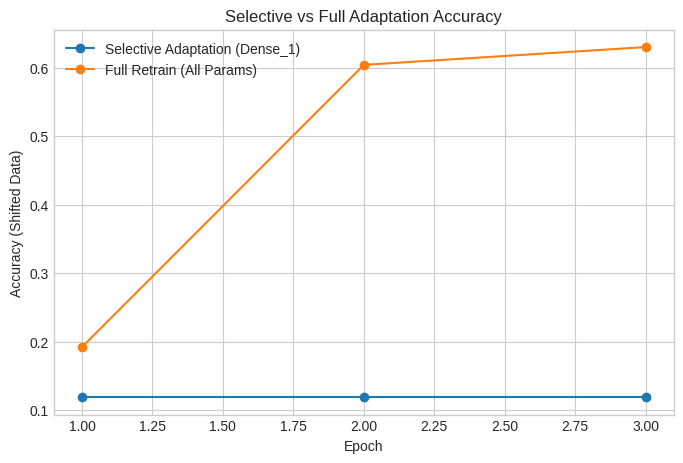

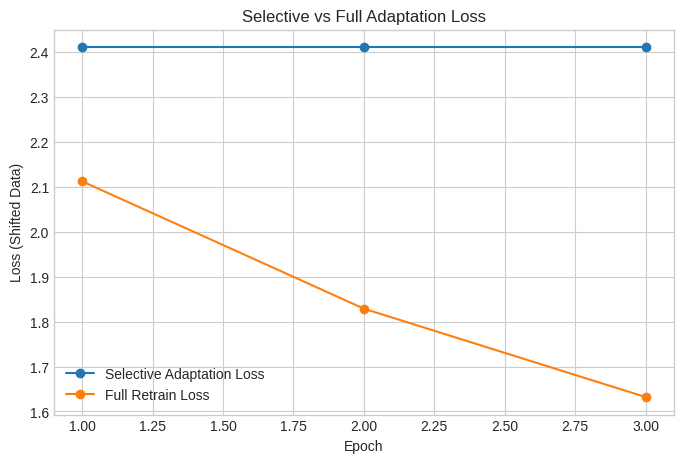

In [28]:
import matplotlib.pyplot as plt

epochs = np.arange(1, num_adapt_epochs + 1)
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(8,5))
plt.plot(epochs, selective_accs, marker='o', label='Selective Adaptation (Dense_1)')
plt.plot(epochs, full_accs, marker='o', label='Full Retrain (All Params)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Shifted Data)')
plt.title('Selective vs Full Adaptation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, selective_losses, marker='o', label='Selective Adaptation Loss')
plt.plot(epochs, full_losses, marker='o', label='Full Retrain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Shifted Data)')
plt.title('Selective vs Full Adaptation Loss')
plt.legend()
plt.grid(True)
plt.show()


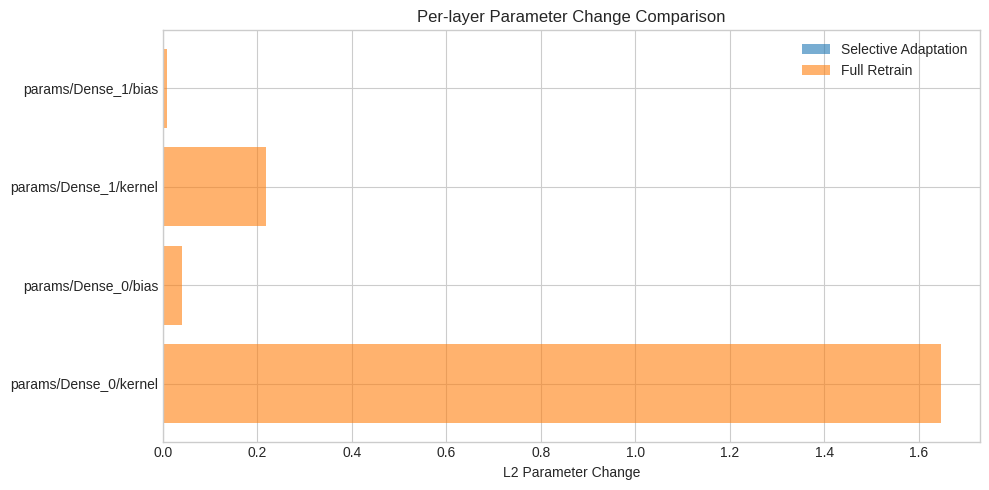

In [24]:
from flax.core import freeze, unfreeze
import numpy as np

def param_diff_norm(params_before, params_after):
    p1 = flax.traverse_util.flatten_dict(unfreeze(params_before))
    p2 = flax.traverse_util.flatten_dict(unfreeze(params_after))
    diffs = {"/".join(k): float(jnp.linalg.norm(p2[k] - p1[k])) for k in p1}
    return diffs

diffs_sel = param_diff_norm(state.params, state_selective.params)
diffs_full = param_diff_norm(state.params, state_full_retrain.params)

plt.figure(figsize=(10,5))
plt.barh(list(diffs_sel.keys()), list(diffs_sel.values()), alpha=0.6, label="Selective Adaptation")
plt.barh(list(diffs_full.keys()), list(diffs_full.values()), alpha=0.6, label="Full Retrain")
plt.xlabel("L2 Parameter Change")
plt.title("Per-layer Parameter Change Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
_, acc_selective = eval_batch(state_selective.params, state_selective.apply_fn, X_test_shifted, y_test)
_, acc_full = eval_batch(state_full_retrain.params, state_full_retrain.apply_fn, X_test_shifted, y_test)
_, acc_orig_after_selective = eval_batch(state_selective.params, state_selective.apply_fn, X_test, y_test)
_, acc_orig_after_full = eval_batch(state_full_retrain.params, state_full_retrain.apply_fn, X_test, y_test)

print("\nFinal comparison on SHIFTED data:")
print(f"Selective-adapt acc (only Dense_1 updated): {float(acc_selective):.4f}")
print(f"Full-retrain acc (all params updated): {float(acc_full):.4f}")

print("\nEffect on ORIGINAL data after adaptation:")
print(f"Selective-adapt acc on original: {float(acc_orig_after_selective):.4f}")
print(f"Full-retrain acc on original:    {float(acc_orig_after_full):.4f}")


Final comparison on SHIFTED data:
Selective-adapt acc (only Dense_1 updated): 0.1190
Full-retrain acc (all params updated): 0.6300

Effect on ORIGINAL data after adaptation:
Selective-adapt acc on original: 0.1150
Full-retrain acc on original:    0.0020


| Stage                    | Description                                | Shifted Acc | Original Acc | Interpretation                                                                                                                                           |
| ------------------------ | ------------------------------------------ | ----------- | ------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Baseline**             | Trained on normal MNIST                    | **0.01**    | **0.915**    | Model performs well on the source domain but completely fails on inverted images.                        |
| **Selective Adaptation** | Retrained only `Dense_1` on inverted MNIST | **0.119**   | **0.115**    | Tiny improvement on shifted domain; catastrophic forgetting on original domain , classifier alone can’t adapt because features (Dense_0) are mismatched. This shows the limitation of naive selective adaptation. To succeed, we need to adapt some earlier representation layers too — or use a smarter update (e.g., EKF, low-rank, or probing-based selection).|
| **Full Retrain**         | Retrained all layers on inverted MNIST     | **0.63**    | **0.002**    | Learns the new domain much better but totally forgets the old one. Classic “plasticity vs. stability” trade-off. the trade-off between adaptation power and memory retention. need to find a middle ground between these.                                         |
